# Logistic Regression

Logistic Regression is a popular technique for Classification problems. This model uses the sigmoid function to calculate the posterior probability of a Class.

Here, the predictions of Logistic Regression are in the form of probabilities of an event occurring, (i.e., the probability of binary classes), given certain attribute values of input variables x.

- The underlying formula for classification of the perceptron algorithm is given by:
    - $\hat{y} = \sigma(w^{T}\phi(x))$, where 
        - $\\sigma(n) = \frac{1}{1+e^{-n}}$ is the sigmoid or logistic function.

- The vector $w$ is obtained by training on a dataset for some iterations using gradient descent or its variants like stochastic Gradient Descent or Mini Batch Gradient Descent.

- The update of w for every misclassified point is then given by: 
   - $w^{\tau + 1} = w^{\tau} + \eta.▽(\sigma(w^{T}\phi(x)))$, 
    - where $\\eta$ is the learning rate,
    - ${w}$ is the weight matrix.
    - $\\phi(x)$ is a transformed feature,
    - The value of the gradient/partial derivative (▽) is given by:
        - $(\hat{y} - y).\hat{y}.(1-\hat{y})$
        - here $y$ is the true value and $\hat{y}=\\sigma(n) = \frac{1}{1+e^{-n}}$ is the predicted value (given by sigma function) for a data point .

## Implementation
- The algorithm uses NumPy,pandas and matplotlib as dependencies
- The training and testing data are vectorized using NumPy to generate predictions without explicit for loops
- The dataset is shuffled to give 10 shuffled datasets. Each of these are split into 70:30, training and testing splits respectively
- For **Grandient Descent Learning** we have choosen three combinations of learning rates and epochs (iterations) to get the best accuracy.
    - In gradient descent we have trained the model on each of the 10 splits and plotted the accuracies and losses. 
    - Also the average test metrics are displayed.
- Later, the same learning rates (but different epochs) were used to train the model using **Stochastic Gradient Descent**.

**Note**: All of the above implementation is present in the 'LogReg' class. Training the shuffled splits has been done later using the 'LogReg' class.

## Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import os
import tqdm
from tqdm import notebook

## Loading Data

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
PARENT = '/gdrive/MyDrive/Projects/ML_Models/'

In [7]:
%cd /gdrive/MyDrive/Projects/ML_Models/

/gdrive/MyDrive/Projects/ML_Models


In [8]:
df =  pd.read_csv('dataset_LR.csv')

In [9]:
df.head()

,attr1,attr2,attr3,attr4,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Model

In [11]:
class LogReg():

    def __init__(self, df, standardize=False, train_size=0.7, randomize=True):
        self.w = None
        self.b = None
        self.df = df
        self.train_size = train_size
        self.randomize = randomize
        self.standardize = standardize
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split()
        if standardize:
            self.standard()
        self.accuracyList =[]
        self.lossList =[]
        self.attrList=[]
        self.tAccuracy=[]
    
    def train_test_split(self):
        '''
        Randomizes the data and Splits the data points into training and testing values in the ratio given.
        '''
        data = np.array(self.df)
        train_size=self.train_size
        
        if self.randomize:
            np.random.shuffle(data)

        X = data[:,:-1]
        y = data[:,-1]

        train = int(train_size * X.shape[0])
        test = int((1-train_size) * X.shape[0])

        X_train = X[0 : train]
        X_test = X[train : train+test] 
        y_train = y[0 : train]
        y_test = y[train : train+test] 

        return X_train, X_test, y_train, y_test

    def standard(self):
        '''
        Normalizes the Data the given data.
        '''
        self.X_train = (self.X_train - self.X_train.mean(axis=0)) / self.X_train.std(axis=0)
        self.X_test = (self.X_test - self.X_train.mean(axis=0)) / self.X_train.std(axis=0)  
  
    def perceptron(self, X):
        '''
        Evaluates the linear combination of the weights and the training data.
        Parameters:
            X: Training Point
        '''
        return np.dot(X, self.w.T) + self.b

    def sigmoid(self, X):
        '''
        Sigmoid Function.
        Parameters:
            X: Training Point
        '''
        return 1.0 / (1.0 + np.exp(-X))

    def grad_w(self, x, y):
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred) * x
  
    def grad_b(self, x, y):
        '''
        Calculates the gradient of x_0 value.
        Parameters:
            x: 
            y: 
        '''
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred)

    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return sum([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])/len([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])
    
    def accuracy(self, y_pred, y):
        '''
        Calculates the accuracy score of the predicted values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        correct = 0
        for i in range(y.shape[0]):
            if y_pred[i]>0.5:
                yp=1
            else:
                yp=0
            if y[i] == yp:
                correct += 1
        return correct / float(y.shape[0])

    def fit(self, X, Y, epochs = 1, learning='GD', learning_rate = 1, batch_size=1, intialize = False, display_loss=False):
        '''
        Trains the model either using Gradient Descent or Stochastic Gradient Descent.
        Parameters:
            X: testing sample
        '''
    
        #intialize
        if intialize:
            self.w = np.random.randn(1, X.shape[1])
            self.b = 0

        if display_loss:
            loss={}
            accuracy={}

        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0
            db = 0

            if learning == 'GD':
                for x, y in zip(X, Y):
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                self.w -= learning_rate * dw
                self.b -= learning_rate * db

            if learning == 'SGD':
                # for j in range(X.shape[0]):
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                dw += self.grad_w(x,y)
                db += self.grad_b(x,y)
                self.w -= learning_rate * dw
                self.b -= learning_rate * db

            if learning == 'MBSGD':
                randInt = np.arange(0, X.shape[0], batch_size)
                np.random.shuffle(randInt)
                for j in range(randInt.shape[0]):
                    x = X[randInt[j], :]
                    y = Y[randInt[j]]
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                self.w -= learning_rate * dw
                self.b -= learning_rate * db

            if display_loss:
                Y_pred = self.sigmoid(self.perceptron(X))
                loss[i] = self.mean_squared_error(Y_pred,Y)[0]
                accuracy[i] = self.accuracy(Y_pred,Y)
                if i%50==0:
                    print('Epoch:', i,'Loss:', loss[i],'Accuracy:', accuracy[i])

        if display_loss:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')

            plt.subplot(2, 1, 2)
            plt.plot(list(accuracy.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            
            plt.show()

            self.attrList += [np.argmax(self.w)+1]
            self.lossList += [loss[epochs-1]]
            self.accuracyList += [accuracy[epochs-1]]

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        # Y_pred = []
        # for x in X:
        #     y_pred = self.sigmoid(self.perceptron(x))
        #     Y_pred.append(y_pred)
        return self.sigmoid(self.perceptron(X))
    
    def binarize(self, X, threshold=0.5):
        '''
        Evaluates the binary labels of the given data.
        Parameters:
            X: testing sample
        '''
        y_pred = self.predict(X)
        Y_p = []
        for y in range(y_pred.shape[0]):
            if y_pred[y]>threshold:
                Y_p+=[1]
            else:
                Y_p+=[0]
        return np.array(Y_p)

    def evaluate(self, x_test, y_test, display_confusion_matrix=True):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''

        y_pred = self.binarize(x_test)
        dict = self.report(y_pred, y_test)
        print('Classification Report') 
        n = np.array(list(dict.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        if display_confusion_matrix:
            self.confusion_matrix(dict)

    def train_k_splits(self, k, epochs=2000, learning = 'GD', learning_rate=0.015, batch_size=1):
        '''
        Performs k-fold validation on the given data.  
        Parameters:
            data
            k: No. of folds
        '''
        
        TP, TN, FP, FN, Total, accuracy, recall, precision=0, 0, 0, 0, 0, 0, 0, 0

        print('Total of 10 Splits:')        
        for i in range(k):

            print()            
            print('Split', i+1,': ')
            X_train, X_test, Y_train, Y_test = self.train_test_split()  
            if self.standardize:
                self.standard()
                
            print('Training the Model...')
            displayLoss=True
            self.fit(X_train, Y_train, epochs, learning=learning, learning_rate=learning_rate , intialize = True, display_loss=displayLoss, batch_size=batch_size)
            print()
            print('Trained the Model.')
            print()

            y_pred = self.binarize(X_test)            
            metric_dict = self.report(y_pred, Y_test)
            print('The most important feature is \'attr', np.argmax(self.w)+1, '\'','with weight', self.w[0][np.argmax(self.w)])
            
            TP+=metric_dict['TP']
            TN+=metric_dict['TN']
            FP+=metric_dict['FP']
            FN+=metric_dict['FN']
            Total+=metric_dict['Total']
            accuracy+=metric_dict['Accuracy']
            self.tAccuracy += [metric_dict['Accuracy']]
            precision+=metric_dict['Precision']
            recall+=metric_dict['Recall']
            
            self.evaluate(X_test, Y_test, display_confusion_matrix=False)
            print('Loss : ', self.lossList[-1])
        
        avg = {'TP':TP/k, 'TN':TN/k, 'FP':FP/k, 'FN':FN/k, 'Total':Total/k, 'Accuracy':accuracy/k, 'Recall':recall/k, 'Precision':precision/k}
        
        print()
        print()
        print('Final Classification Report (Average Values across ', k, ' splits)') 
        n = np.array(list(avg.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        print('Average Loss : ', np.array(self.lossList).mean())
        print('Most important feature is \'attr', np.argmax(np.bincount(self.attrList)), '\'')
        self.confusion_matrix(avg)
    
    def report(self, y_pred, y_test):
        '''
        calculates precision and recall metrics
        Parameters:
            y_pred: predicted labels on a testing set
            y_test: true labels of the testing set
        '''
        
        TP=0
        TN=0
        FP=0
        FN=0
        Total=len(y_pred)
        for pred, test in zip(y_pred, y_test):
            if pred==test:
                if pred==0:
                    TN+=1
                else:
                    TP+=1
            else:
                if pred==1:
                    FP+=1
                else:
                    FN+=1
        
        accuracy = (TP+TN) / Total
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        
        return {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'Total':Total, 'Accuracy':accuracy, 'Recall':recall, 'Precision':precision}
        
    def confusion_matrix(self, report_val):
        '''
        Plots the confusion Matrix of the given data.
        '''
        
        fig, ax = plt.subplots()
        classes = ['Positive', 'Negitive']
        t = report_val['Total']
        report = np.array([[report_val['TN']/t, report_val['FP']/t], [report_val['FN']/t, report_val['TP']/t]])
        im = ax.imshow(report, cmap = 'Blues')

        ax.set_xticks(np.arange(len(classes)))
        ax.set_yticks(np.arange(len(classes)))

        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)


        plt.setp(ax.get_xticklabels(), rotation_mode="anchor")
        
        group_names = ['True Neg','False Pos', 'False Neg','True Pos']
        group_percentages = ['{0:.2%}'.format(value) for value in report.flatten()]

        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        for i in range(len(classes)):
            for j in range(len(classes)):
                text = ax.text(j, i, labels[i, j], ha="center", va="center")

        ax.set_title('Confusion Matrix', fontdict = {'size':18}, pad = 20)
        
        fig.tight_layout()
        plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
        plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
        plt.show()

## Gradient Descent

In **Gradient Descent** we iterate over all the $n$ training points and update the weights (matrix) at each point in each epoch of learning. 

The weights are updated in such a way that we minimize the loss, by moving downwards along the gradient to reach the global minima.

Each update is given by:
 - $w^{\tau + 1} = w^{\tau} + \eta.\sum_{i=1}^n{▽(\sigma(w^{T}\phi(x_{n})))}$, 
    - where $\\eta$ is the learning rate,
    - ${w}$ is the weight matrix.
    - $\\phi(x_{n})$ is the transformed feature of the nth data point.
    - The value of the gradient/partial derivative (▽) is given by:
        - $(\hat{y} - y).\hat{y}.(1-\hat{y})$
        , here $\hat{y}=\sigma(w^{T}\phi(x_{n})) = \frac{1}{1+e^{-w^{T}\phi(x_{n})}}$



The model has been trained on the learning rates 0.015, 0.1, and 0.5 using Gradient Decsent.

We have normalized the dataset for 0.1 and 0.5 learning rates. This has given a better accuracy in gradient Descent.

### Learning Rate = 0.015 and Epochs = 300 - Accuracy = 98.95% - No Normalization

In [109]:
GD = LogReg(df)

Total of 10 Splits:

Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.37427738702442404 Accuracy: 0.5927083333333333
Epoch: 50 Loss: 0.011288799353929789 Accuracy: 0.984375
Epoch: 100 Loss: 0.010163053768373426 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.00790869335709446 Accuracy: 0.9895833333333334
Epoch: 200 Loss: 0.008732050040188268 Accuracy: 0.9916666666666667
Epoch: 250 Loss: 0.007553671216812963 Accuracy: 0.9885416666666667



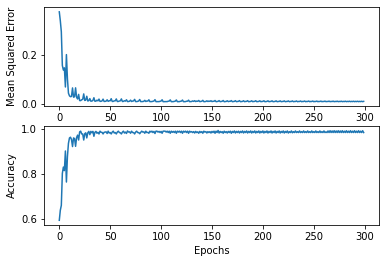


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.10361364071869399
Classification Report
                             
TP                        176
TN                        232
FP                          0
FN                          3
Total                     411
Accuracy   0.9927007299270073
Recall     0.9832402234636871
Precision                 1.0
Loss :  0.008849218570123735

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.13848209993283508 Accuracy: 0.8270833333333333
Epoch: 50 Loss: 0.015308135069748601 Accuracy: 0.9791666666666666
Epoch: 100 Loss: 0.007887419756035912 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.007594015792612785 Accuracy: 0.9864583333333333
Epoch: 200 Loss: 0.00821993230120655 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.008057067961037624 Accuracy: 0.9895833333333334



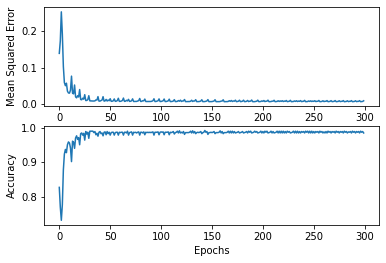


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.15787561223791205
Classification Report
                             
TP                        182
TN                        225
FP                          2
FN                          2
Total                     411
Accuracy   0.9902676399026764
Recall     0.9891304347826086
Precision  0.9891304347826086
Loss :  0.009728113426988759

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.4017045677168884 Accuracy: 0.56875
Epoch: 50 Loss: 0.0089121224828146 Accuracy: 0.9895833333333334
Epoch: 100 Loss: 0.007714289132202052 Accuracy: 0.990625
Epoch: 150 Loss: 0.007373728545674672 Accuracy: 0.9864583333333333
Epoch: 200 Loss: 0.007657909337932525 Accuracy: 0.9864583333333333
Epoch: 250 Loss: 0.01003026413860294 Accuracy: 0.9854166666666667



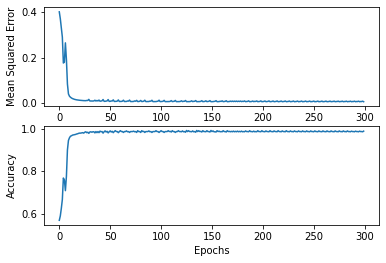


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.19846991639653633
Classification Report
                             
TP                        184
TN                        224
FP                          1
FN                          2
Total                     411
Accuracy   0.9927007299270073
Recall      0.989247311827957
Precision  0.9945945945945946
Loss :  0.0072199161241675025

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.21846878001567216 Accuracy: 0.7572916666666667
Epoch: 50 Loss: 0.02184587478269587 Accuracy: 0.9739583333333334
Epoch: 100 Loss: 0.009762150564214755 Accuracy: 0.9875
Epoch: 150 Loss: 0.008464209158560615 Accuracy: 0.9875
Epoch: 200 Loss: 0.014138911885744178 Accuracy: 0.9833333333333333
Epoch: 250 Loss: 0.008694935849735746 Accuracy: 0.9885416666666667



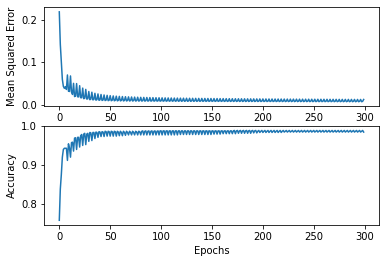


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.2997256935860395
Classification Report
                             
TP                        179
TN                        229
FP                          1
FN                          2
Total                     411
Accuracy   0.9927007299270073
Recall      0.988950276243094
Precision  0.9944444444444445
Loss :  0.012893811670440541

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.240473331831023 Accuracy: 0.7166666666666667
Epoch: 50 Loss: 0.00888542321462315 Accuracy: 0.990625
Epoch: 100 Loss: 0.007579292083015596 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.006897960374983513 Accuracy: 0.990625
Epoch: 200 Loss: 0.0064354971474029484 Accuracy: 0.9916666666666667
Epoch: 250 Loss: 0.006088012082770733 Accuracy: 0.9916666666666667



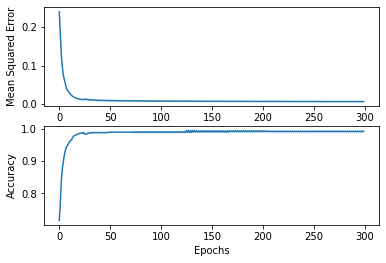


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.1925461353188946
Classification Report
                             
TP                        189
TN                        215
FP                          3
FN                          4
Total                     411
Accuracy   0.9829683698296837
Recall     0.9792746113989638
Precision            0.984375
Loss :  0.005395908901653291

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.5548834723298499 Accuracy: 0.41458333333333336
Epoch: 50 Loss: 0.01087954504808769 Accuracy: 0.984375
Epoch: 100 Loss: 0.01703507948562971 Accuracy: 0.978125
Epoch: 150 Loss: 0.00975823062999922 Accuracy: 0.9854166666666667
Epoch: 200 Loss: 0.008644035290793769 Accuracy: 0.9854166666666667
Epoch: 250 Loss: 0.013749518131816386 Accuracy: 0.9833333333333333



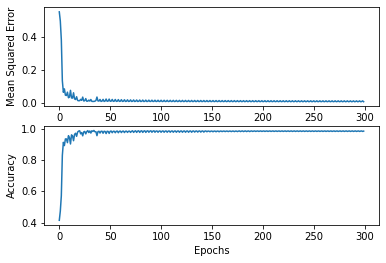


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.27325386621886705
Classification Report
                             
TP                        188
TN                        222
FP                          1
FN                          0
Total                     411
Accuracy   0.9975669099756691
Recall                    1.0
Precision  0.9947089947089947
Loss :  0.008203680809024883

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.31048313609164807 Accuracy: 0.6697916666666667
Epoch: 50 Loss: 0.007963898056129603 Accuracy: 0.9895833333333334
Epoch: 100 Loss: 0.006316574681467107 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.006123427873381688 Accuracy: 0.9927083333333333
Epoch: 200 Loss: 0.006020396084917439 Accuracy: 0.9927083333333333
Epoch: 250 Loss: 0.0059299454173959406 Accuracy: 0.9927083333333333



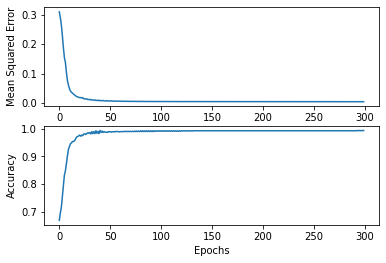


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.33715603171357855
Classification Report
                             
TP                        184
TN                        221
FP                          5
FN                          1
Total                     411
Accuracy   0.9854014598540146
Recall     0.9945945945945946
Precision  0.9735449735449735
Loss :  0.005854432150721537

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.6211028129669599 Accuracy: 0.3572916666666667
Epoch: 50 Loss: 0.00788716254037094 Accuracy: 0.9895833333333334
Epoch: 100 Loss: 0.007205598717124074 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.006529178444411354 Accuracy: 0.990625
Epoch: 200 Loss: 0.008102384705024954 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.0066375494475267695 Accuracy: 0.9895833333333334



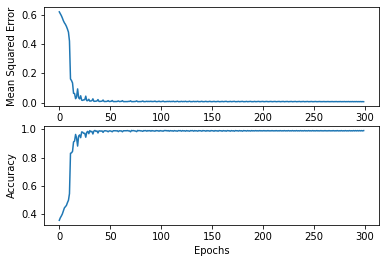


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.26458722177398974
Classification Report
                             
TP                        190
TN                        215
FP                          4
FN                          2
Total                     411
Accuracy   0.9854014598540146
Recall     0.9895833333333334
Precision   0.979381443298969
Loss :  0.0062298687745719035

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.5551273131132326 Accuracy: 0.42083333333333334
Epoch: 50 Loss: 0.008418544707105688 Accuracy: 0.9885416666666667
Epoch: 100 Loss: 0.007911016599260457 Accuracy: 0.9916666666666667
Epoch: 150 Loss: 0.006463972296522842 Accuracy: 0.9885416666666667
Epoch: 200 Loss: 0.006431182214711168 Accuracy: 0.9885416666666667
Epoch: 250 Loss: 0.006943464962569712 Accuracy: 0.9916666666666667



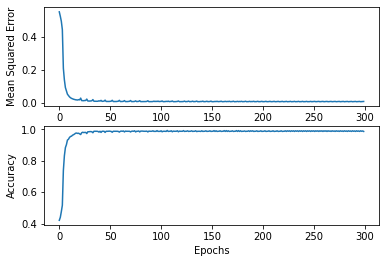


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.18842875234168904
Classification Report
                             
TP                        177
TN                        228
FP                          3
FN                          3
Total                     411
Accuracy   0.9854014598540146
Recall     0.9833333333333333
Precision  0.9833333333333333
Loss :  0.007871802612965105

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.4455829867486501 Accuracy: 0.5302083333333333
Epoch: 50 Loss: 0.010703415739033167 Accuracy: 0.9875
Epoch: 100 Loss: 0.015026426472083227 Accuracy: 0.9833333333333333
Epoch: 150 Loss: 0.011999558433269561 Accuracy: 0.984375
Epoch: 200 Loss: 0.0073330031872202595 Accuracy: 0.990625
Epoch: 250 Loss: 0.007963654512437305 Accuracy: 0.9875



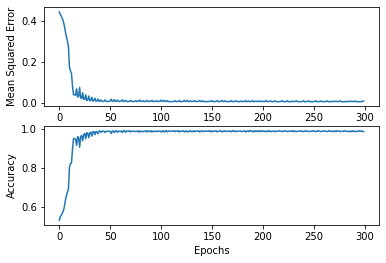


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.14514839098064816
Classification Report
                             
TP                        187
TN                        220
FP                          2
FN                          2
Total                     411
Accuracy   0.9902676399026764
Recall     0.9894179894179894
Precision  0.9894179894179894
Loss :  0.010171056985081996


Final Classification Report (Average Values across  10  splits)
                             
TP                      183.6
TN                      223.1
FP                        2.2
FN                        2.1
Total                   411.0
Accuracy   0.9895377128953772
Recall      0.988677210839556
Precision  0.9882931208125907
Average Loss :  0.008241781002573926
Most important feature is 'attr 4 '


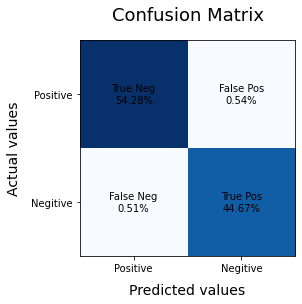

In [110]:
GD.train_k_splits(10, epochs=300, learning_rate=0.015)

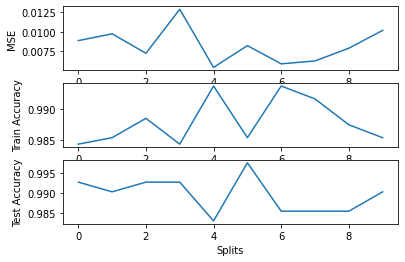

In [111]:
plt.subplot(3, 1, 1)
plt.plot(GD.lossList[:10])
plt.xlabel('Splits')
plt.ylabel('MSE')

plt.subplot(3, 1, 2)
plt.plot(GD.accuracyList[:10])
plt.xlabel('Splits')
plt.ylabel('Train Accuracy')

plt.subplot(3, 1, 3)
plt.plot(GD.tAccuracy[:10])
plt.xlabel('Splits')
plt.ylabel('Test Accuracy')

plt.show()

### Learning Rate = 0.1 and Epochs = 200 - Accuracy = 98.49% - Normalized

In [12]:
GD1 = LogReg(df, standardize=True)

Total of 10 Splits:

Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.31697799019107364 Accuracy: 0.6739583333333333
Epoch: 50 Loss: 0.007305149396775518 Accuracy: 0.990625
Epoch: 100 Loss: 0.008649421254671849 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.011293733037978983 Accuracy: 0.9875



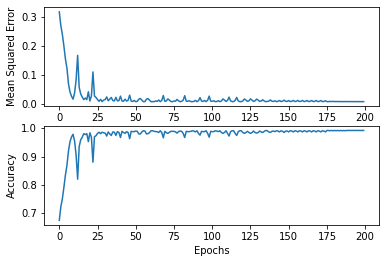


Trained the Model.

The most important feature is 'attr 4 ' with weight -1.5616455227303083
Classification Report
                             
TP                        180
TN                        228
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9836065573770492
Loss :  0.007578033235991764

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.38541660925169985 Accuracy: 0.5989583333333334
Epoch: 50 Loss: 0.010488128605009424 Accuracy: 0.9854166666666667
Epoch: 100 Loss: 0.007196127835705885 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.009821502704138741 Accuracy: 0.9875



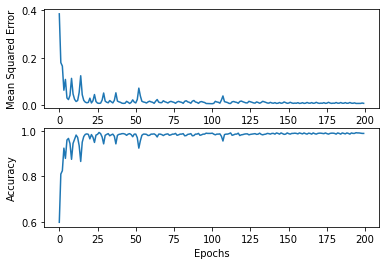


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.953435336668488
Classification Report
                             
TP                        196
TN                        210
FP                          2
FN                          3
Total                     411
Accuracy   0.9878345498783455
Recall     0.9849246231155779
Precision    0.98989898989899
Loss :  0.008743548429226821

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.5949460480542755 Accuracy: 0.3854166666666667
Epoch: 50 Loss: 0.021009160573925566 Accuracy: 0.9770833333333333
Epoch: 100 Loss: 0.0074133001232907355 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.029065424967254807 Accuracy: 0.9666666666666667



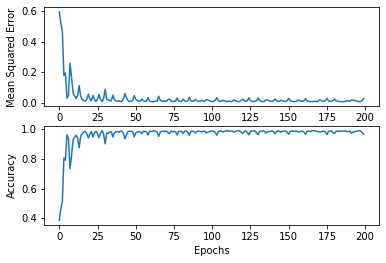


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.834358283453164
Classification Report
                             
TP                        165
TN                        233
FP                          2
FN                         11
Total                     411
Accuracy   0.9683698296836983
Recall                 0.9375
Precision  0.9880239520958084
Loss :  0.028233268903810838

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.28210427206934324 Accuracy: 0.7104166666666667
Epoch: 50 Loss: 0.022260968724579857 Accuracy: 0.9760416666666667
Epoch: 100 Loss: 0.005827454872022924 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.006804971726555448 Accuracy: 0.9916666666666667



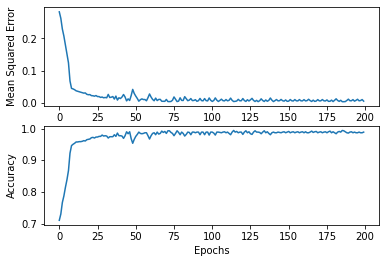


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.28109119200145194
Classification Report
                             
TP                        176
TN                        229
FP                          3
FN                          3
Total                     411
Accuracy   0.9854014598540146
Recall     0.9832402234636871
Precision  0.9832402234636871
Loss :  0.006716101972970028

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.11108677236573686 Accuracy: 0.8791666666666667
Epoch: 50 Loss: 0.01969908998182346 Accuracy: 0.9770833333333333
Epoch: 100 Loss: 0.011772841382826825 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.0066200946940994 Accuracy: 0.9916666666666667



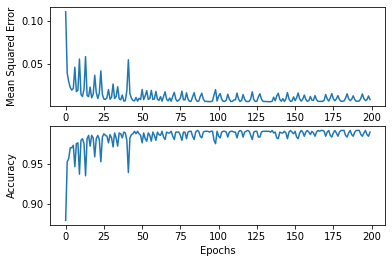


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.7559988548252656
Classification Report
                             
TP                        180
TN                        224
FP                          4
FN                          3
Total                     411
Accuracy   0.9829683698296837
Recall     0.9836065573770492
Precision  0.9782608695652174
Loss :  0.007866527417247329

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.3232450345423554 Accuracy: 0.6520833333333333
Epoch: 50 Loss: 0.009660961726422074 Accuracy: 0.9875
Epoch: 100 Loss: 0.007467382998486514 Accuracy: 0.990625
Epoch: 150 Loss: 0.008172327735599918 Accuracy: 0.9895833333333334



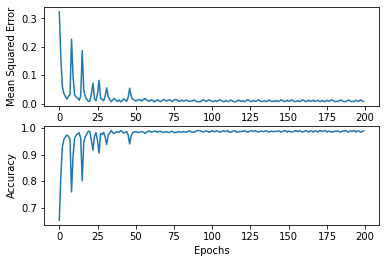


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.5197735920245838
Classification Report
                             
TP                        196
TN                        211
FP                          3
FN                          1
Total                     411
Accuracy   0.9902676399026764
Recall     0.9949238578680203
Precision  0.9849246231155779
Loss :  0.007232845497638976

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.15758519723049097 Accuracy: 0.8364583333333333
Epoch: 50 Loss: 0.01439928705891768 Accuracy: 0.9833333333333333
Epoch: 100 Loss: 0.010506075000532855 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.014821034879588564 Accuracy: 0.9822916666666667



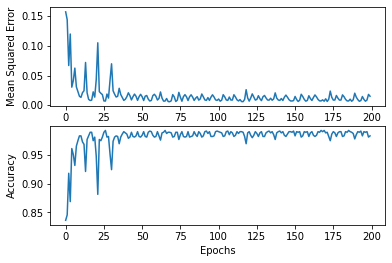


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.6737179712315416
Classification Report
                             
TP                        191
TN                        213
FP                          3
FN                          4
Total                     411
Accuracy   0.9829683698296837
Recall     0.9794871794871794
Precision  0.9845360824742269
Loss :  0.01521056001194423

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.1885372578453956 Accuracy: 0.803125
Epoch: 50 Loss: 0.005495586056082404 Accuracy: 0.9916666666666667
Epoch: 100 Loss: 0.005842812153511097 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.005478070730721994 Accuracy: 0.99375



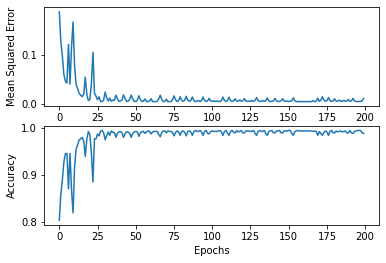


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.81358369250801
Classification Report
                             
TP                        171
TN                        232
FP                          5
FN                          3
Total                     411
Accuracy   0.9805352798053528
Recall     0.9827586206896551
Precision  0.9715909090909091
Loss :  0.011809291890864873

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.19837249657008116 Accuracy: 0.7854166666666667
Epoch: 50 Loss: 0.009009570514039942 Accuracy: 0.9864583333333333
Epoch: 100 Loss: 0.009796484298736217 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.00791128006635877 Accuracy: 0.990625



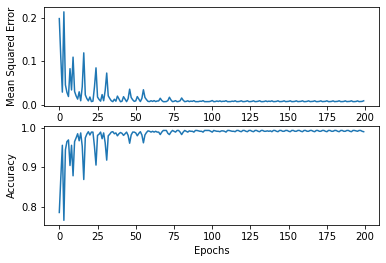


Trained the Model.

The most important feature is 'attr 4 ' with weight -1.0545606659282951
Classification Report
                             
TP                        191
TN                        216
FP                          3
FN                          1
Total                     411
Accuracy   0.9902676399026764
Recall     0.9947916666666666
Precision  0.9845360824742269
Loss :  0.009162612422580306

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.31671182609008997 Accuracy: 0.6697916666666667
Epoch: 50 Loss: 0.02200410498438192 Accuracy: 0.9760416666666667
Epoch: 100 Loss: 0.009115744217422008 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.009378127009818275 Accuracy: 0.9885416666666667



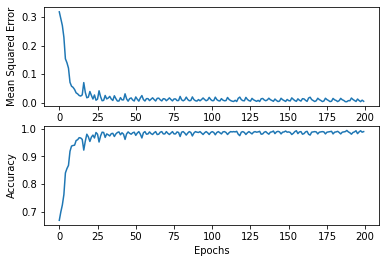


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.6724633318260232
Classification Report
                             
TP                        175
TN                        231
FP                          2
FN                          3
Total                     411
Accuracy   0.9878345498783455
Recall     0.9831460674157303
Precision  0.9887005649717514
Loss :  0.007019949557556604


Final Classification Report (Average Values across  10  splits)
                             
TP                      182.1
TN                      222.7
FP                        3.0
FN                        3.2
Total                   411.0
Accuracy   0.9849148418491482
Recall     0.9824378796083565
Precision  0.9837318854527444
Average Loss :  0.010957273933983176
Most important feature is 'attr 4 '


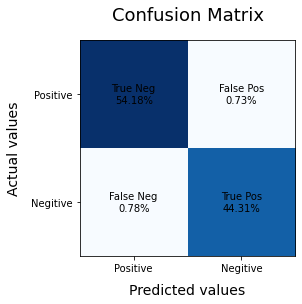

In [13]:
GD1.train_k_splits(10, epochs=200, learning_rate=0.1)

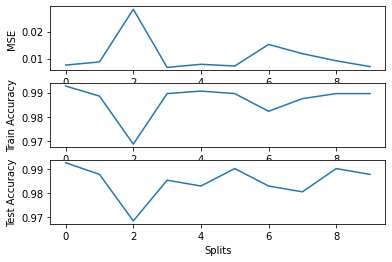

In [14]:
plt.subplot(3, 1, 1)
plt.plot(GD1.lossList[:10])
plt.xlabel('Splits')
plt.ylabel('MSE')

plt.subplot(3, 1, 2)
plt.plot(GD1.accuracyList[:10])
plt.xlabel('Splits')
plt.ylabel('Train Accuracy')

plt.subplot(3, 1, 3)
plt.plot(GD1.tAccuracy[:10])
plt.xlabel('Splits')
plt.ylabel('Test Accuracy')

plt.show()

### Learning Rate =0.5 and Epochs = 500 - Accuracy = 99.42% - Standardized Data

In [114]:
GD2 = LogReg(df, standardize=True)

Total of 10 Splits:

Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.1874721707142445 Accuracy: 0.809375
Epoch: 50 Loss: 0.029917807441949548 Accuracy: 0.9677083333333333
Epoch: 100 Loss: 0.01624878742932027 Accuracy: 0.9833333333333333
Epoch: 150 Loss: 0.014640011390039755 Accuracy: 0.984375
Epoch: 200 Loss: 0.012233361281275919 Accuracy: 0.9864583333333333
Epoch: 250 Loss: 0.007303197273507704 Accuracy: 0.9927083333333333
Epoch: 300 Loss: 0.006238539877098948 Accuracy: 0.99375
Epoch: 350 Loss: 0.019937055217414845 Accuracy: 0.9802083333333333
Epoch: 400 Loss: 0.017535896988874023 Accuracy: 0.98125
Epoch: 450 Loss: 0.005091331038461557 Accuracy: 0.9947916666666666



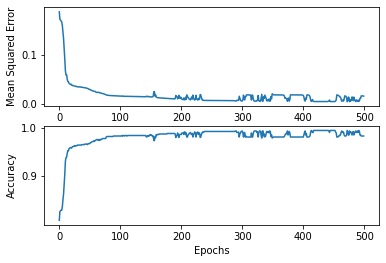


Trained the Model.

The most important feature is 'attr 4 ' with weight -3.0372888121562647
Classification Report
                             
TP                        160
TN                        243
FP                          2
FN                          6
Total                     411
Accuracy   0.9805352798053528
Recall      0.963855421686747
Precision  0.9876543209876543
Loss :  0.016178037370170466

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.16062645402187609 Accuracy: 0.8270833333333333
Epoch: 50 Loss: 0.01815990454530881 Accuracy: 0.98125
Epoch: 100 Loss: 0.005212599240656745 Accuracy: 0.9947916666666666
Epoch: 150 Loss: 0.005211652335100461 Accuracy: 0.9947916666666666
Epoch: 200 Loss: 0.005211118876100823 Accuracy: 0.9947916666666666
Epoch: 250 Loss: 0.005210787828634532 Accuracy: 0.9947916666666666
Epoch: 300 Loss: 0.00521056985024403 Accuracy: 0.9947916666666666
Epoch: 350 Loss: 0.005210420567473692 Accuracy: 0.9947916666666666
Epoch: 400 Loss: 0.005210315449773872 Accuracy: 0.9947916666666666
Epoch: 450 Loss: 0.005210239864490607 Accuracy: 0.9947916666666666



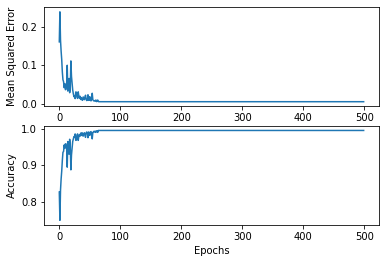


Trained the Model.

The most important feature is 'attr 4 ' with weight -4.680064484956477
Classification Report
                             
TP                        179
TN                        227
FP                          5
FN                          0
Total                     411
Accuracy   0.9878345498783455
Recall                    1.0
Precision  0.9728260869565217
Loss :  0.005210185537045248

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.04748318843133885 Accuracy: 0.9447916666666667
Epoch: 50 Loss: 0.00939918760275834 Accuracy: 0.990625
Epoch: 100 Loss: 0.0072958226450592295 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.007295413818230508 Accuracy: 0.9927083333333333
Epoch: 200 Loss: 0.007295198614717208 Accuracy: 0.9927083333333333
Epoch: 250 Loss: 0.007295073178613914 Accuracy: 0.9927083333333333
Epoch: 300 Loss: 0.007294992803555104 Accuracy: 0.9927083333333333
Epoch: 350 Loss: 0.007294936444276855 Accuracy: 0.9927083333333333
Epoch: 400 Loss: 0.007294893655044708 Accuracy: 0.9927083333333333
Epoch: 450 Loss: 0.0072948590464156195 Accuracy: 0.9927083333333333



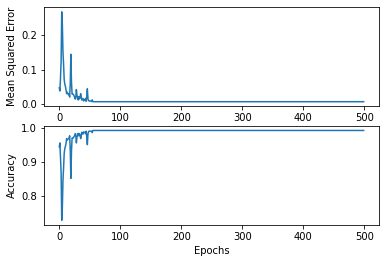


Trained the Model.

The most important feature is 'attr 4 ' with weight -3.500480881647176
Classification Report
                             
TP                        179
TN                        229
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9835164835164835
Loss :  0.0072948302799006205

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.3512142063114466 Accuracy: 0.646875
Epoch: 50 Loss: 0.010110409311218089 Accuracy: 0.9895833333333334
Epoch: 100 Loss: 0.012554258110857558 Accuracy: 0.9864583333333333
Epoch: 150 Loss: 0.005218440550569415 Accuracy: 0.9947916666666666
Epoch: 200 Loss: 0.005213771535482099 Accuracy: 0.9947916666666666
Epoch: 250 Loss: 0.005212046740958025 Accuracy: 0.9947916666666666
Epoch: 300 Loss: 0.0052111557197660864 Accuracy: 0.9947916666666666
Epoch: 350 Loss: 0.005210613861075689 Accuracy: 0.9947916666666666
Epoch: 400 Loss: 0.005210250575380443 Accuracy: 0.9947916666666666
Epoch: 450 Loss: 0.005209990630910946 Accuracy: 0.9947916666666666



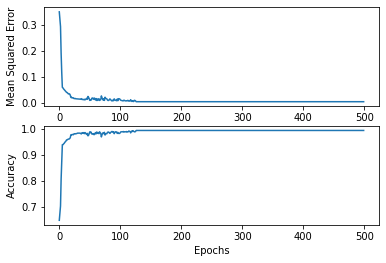


Trained the Model.

The most important feature is 'attr 4 ' with weight -5.106010592688675
Classification Report
                             
TP                        186
TN                        220
FP                          5
FN                          0
Total                     411
Accuracy   0.9878345498783455
Recall                    1.0
Precision  0.9738219895287958
Loss :  0.0052097991784077246

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.3147264652038734 Accuracy: 0.6833333333333333
Epoch: 50 Loss: 0.02043663921909192 Accuracy: 0.978125
Epoch: 100 Loss: 0.00891879371980379 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.015007865257194147 Accuracy: 0.984375
Epoch: 200 Loss: 0.009217784529373748 Accuracy: 0.990625
Epoch: 250 Loss: 0.007014118348829488 Accuracy: 0.9927083333333333
Epoch: 300 Loss: 0.005210843411739084 Accuracy: 0.9947916666666666
Epoch: 350 Loss: 0.005210503639752954 Accuracy: 0.9947916666666666
Epoch: 400 Loss: 0.005210333012905426 Accuracy: 0.9947916666666666
Epoch: 450 Loss: 0.005210222847777214 Accuracy: 0.9947916666666666



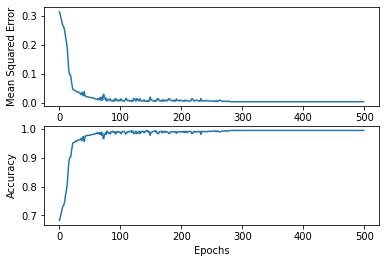


Trained the Model.

The most important feature is 'attr 4 ' with weight -4.2426105738136055
Classification Report
                             
TP                        185
TN                        221
FP                          5
FN                          0
Total                     411
Accuracy   0.9878345498783455
Recall                    1.0
Precision  0.9736842105263158
Loss :  0.0052101393341386585

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.11490161862340639 Accuracy: 0.88125
Epoch: 50 Loss: 0.021361943010066012 Accuracy: 0.9770833333333333
Epoch: 100 Loss: 0.020018192885121147 Accuracy: 0.9791666666666666
Epoch: 150 Loss: 0.005213712921029229 Accuracy: 0.9947916666666666
Epoch: 200 Loss: 0.007174108196277045 Accuracy: 0.9927083333333333
Epoch: 250 Loss: 0.007346690670980454 Accuracy: 0.9927083333333333
Epoch: 300 Loss: 0.006700078439116084 Accuracy: 0.9927083333333333
Epoch: 350 Loss: 0.006269872188751818 Accuracy: 0.99375
Epoch: 400 Loss: 0.00626461964243213 Accuracy: 0.99375
Epoch: 450 Loss: 0.006261527892040724 Accuracy: 0.99375



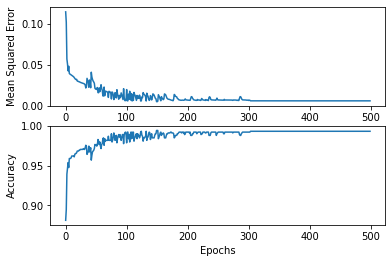


Trained the Model.

The most important feature is 'attr 4 ' with weight -3.6369304119165626
Classification Report
                             
TP                        168
TN                        239
FP                          4
FN                          0
Total                     411
Accuracy   0.9902676399026764
Recall                    1.0
Precision  0.9767441860465116
Loss :  0.006259532404216798

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.3118647697489488 Accuracy: 0.6854166666666667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp


Epoch: 50 Loss: 0.173667666939632 Accuracy: 0.825
Epoch: 100 Loss: 0.07140111805475141 Accuracy: 0.9260416666666667
Epoch: 150 Loss: 0.02187371858270872 Accuracy: 0.978125
Epoch: 200 Loss: 0.018588261339985854 Accuracy: 0.98125
Epoch: 250 Loss: 0.012265747666125875 Accuracy: 0.9875
Epoch: 300 Loss: 0.011476803669593576 Accuracy: 0.9885416666666667
Epoch: 350 Loss: 0.011473960633678209 Accuracy: 0.9885416666666667
Epoch: 400 Loss: 0.011472016001611763 Accuracy: 0.9885416666666667
Epoch: 450 Loss: 0.011470420896815634 Accuracy: 0.9885416666666667



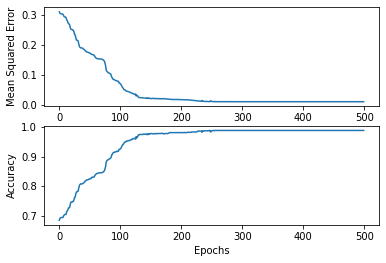


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.7661530613404449
Classification Report
                             
TP                        183
TN                        225
FP                          0
FN                          3
Total                     411
Accuracy   0.9927007299270073
Recall     0.9838709677419355
Precision                 1.0
Loss :  0.011469124091682693

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.31767532745136545 Accuracy: 0.6822916666666666
Epoch: 50 Loss: 0.3153660126814885 Accuracy: 0.684375
Epoch: 100 Loss: 0.2954859523319774 Accuracy: 0.703125
Epoch: 150 Loss: 0.2872187165568594 Accuracy: 0.7125
Epoch: 200 Loss: 0.013531085567226622 Accuracy: 0.9854166666666667
Epoch: 250 Loss: 0.006290397007297836 Accuracy: 0.99375
Epoch: 300 Loss: 0.006260707850268988 Accuracy: 0.99375
Epoch: 350 Loss: 0.006256079594758517 Accuracy: 0.99375
Epoch: 400 Loss: 0.006254239310422304 Accuracy: 0.99375
Epoch: 450 Loss: 0.006253260428913968 Accuracy: 0.99375



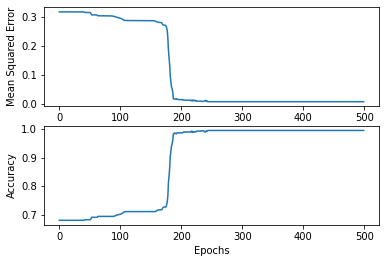


Trained the Model.

The most important feature is 'attr 4 ' with weight -8.503379354109677
Classification Report
                             
TP                        186
TN                        221
FP                          4
FN                          0
Total                     411
Accuracy   0.9902676399026764
Recall                    1.0
Precision  0.9789473684210527
Loss :  0.006252667654702564

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.2888737055996671 Accuracy: 0.709375
Epoch: 50 Loss: 0.02259658709473143 Accuracy: 0.9770833333333333
Epoch: 100 Loss: 0.013409257647042587 Accuracy: 0.9864583333333333
Epoch: 150 Loss: 0.007294035051494904 Accuracy: 0.9927083333333333
Epoch: 200 Loss: 0.007293736254073873 Accuracy: 0.9927083333333333
Epoch: 250 Loss: 0.007293611955284476 Accuracy: 0.9927083333333333
Epoch: 300 Loss: 0.007293534831876136 Accuracy: 0.9927083333333333
Epoch: 350 Loss: 0.007293472847428183 Accuracy: 0.9927083333333333
Epoch: 400 Loss: 0.007293417715794274 Accuracy: 0.9927083333333333
Epoch: 450 Loss: 0.007293366888415595 Accuracy: 0.9927083333333333



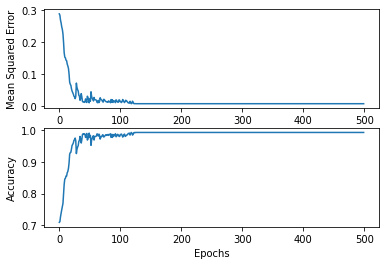


Trained the Model.

The most important feature is 'attr 4 ' with weight -4.379144611276005
Classification Report
                             
TP                        179
TN                        229
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9835164835164835
Loss :  0.0072933203132374055

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.08394109366115628 Accuracy: 0.9114583333333334
Epoch: 50 Loss: 0.019595465091696174 Accuracy: 0.9791666666666666
Epoch: 100 Loss: 0.011432970248791113 Accuracy: 0.9864583333333333
Epoch: 150 Loss: 0.022278978018872624 Accuracy: 0.9760416666666667
Epoch: 200 Loss: 0.015039585686644794 Accuracy: 0.984375
Epoch: 250 Loss: 0.014514363110214725 Accuracy: 0.9854166666666667
Epoch: 300 Loss: 0.011497671487066664 Accuracy: 0.9854166666666667
Epoch: 350 Loss: 0.013621937280258706 Accuracy: 0.9854166666666667
Epoch: 400 Loss: 0.014369769731212319 Accuracy: 0.9854166666666667
Epoch: 450 Loss: 0.011472804277696168 Accuracy: 0.9864583333333333



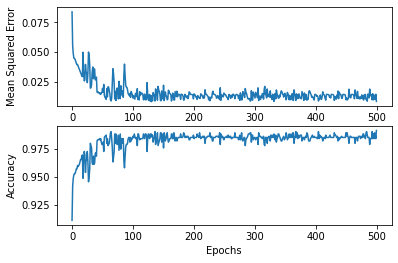


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.05288177320027279
Classification Report
                             
TP                        174
TN                        236
FP                          0
FN                          1
Total                     411
Accuracy   0.9975669099756691
Recall     0.9942857142857143
Precision                 1.0
Loss :  0.008717488583758053


Final Classification Report (Average Values across  10  splits)
                             
TP                      177.9
TN                      229.0
FP                        3.1
FN                        1.0
Total                   411.0
Accuracy   0.9900243309002432
Recall     0.9942012103714397
Precision  0.9830711129499818
Average Loss :  0.007909512474726023
Most important feature is 'attr 4 '


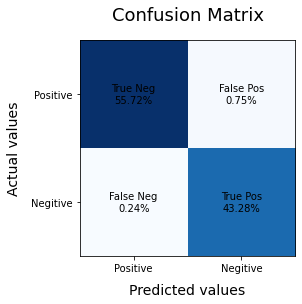

In [115]:
GD2.train_k_splits(10, epochs=500, learning_rate=0.5)

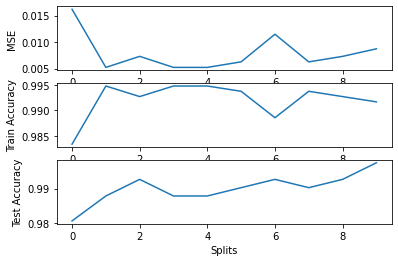

In [116]:
plt.subplot(3, 1, 1)
plt.plot(GD2.lossList[:10])
plt.xlabel('Splits')
plt.ylabel('MSE')

plt.subplot(3, 1, 2)
plt.plot(GD2.accuracyList[:10])
plt.xlabel('Splits')
plt.ylabel('Train Accuracy')

plt.subplot(3, 1, 3)
plt.plot(GD2.tAccuracy[:10])
plt.xlabel('Splits')
plt.ylabel('Test Accuracy')

plt.show()

## Stochastic Gradient Descent

Gradient Descent gives us the accurate minima, by converging at the local/global minima of the loss, but it takes a long time to iterate over all the data points in each epoch. Therefore, in practice people prefer using **Stochastic Gradient Descent**

In **Stochastic Gradient Descent**, we randomly pick a data point and update the weights based on only that data point in each epoch. 

This variant of learning takes place slower, but it is proven that this method of learning always converges to a range of values around the minima. This range is called the **Region of Confusion** (From the perspective of data science, having a small margin of error from the original value is desired, and this method of learning will assure that).


Each update is given by the below, where the data point $x_{n}$ is choosen randomly in each epoch:
 - $w^{\tau + 1} = w^{\tau} + \eta.▽(\sigma(w^{T}\phi(x_{n})))$, 
    - where $\\eta$ is the learning rate,
    - ${w}$ is the weight matrix.
    - $\\phi(x_{n})$ is the transformed feature of the nth data point.
    - The value of the gradient/partial derivative (▽) is given by:
        - $(\hat{y} - y).\hat{y}.(1-\hat{y})$
        , here $\hat{y}=\sigma(w^{T}\phi(x_{n})) = \frac{1}{1+e^{-w^{T}\phi(x_{n})}}$



The above model has been trained on the learning rates 0.015, 0.1, and 0.5, using Stochastic Gradient Descent.

We have not normalized the datasets in SGD learning, as it was showing very poor results.

### Learning Rate = 0.015 and Epochs = 2000 - Accuracy = 94.40% - Not Standardized

Training the model using the final split of 'GD' training.

Epoch: 0 Loss: 0.21368036009882604 Accuracy: 0.6958333333333333
Epoch: 50 Loss: 0.1832062079565181 Accuracy: 0.740625
Epoch: 100 Loss: 0.1595675007518148 Accuracy: 0.775
Epoch: 150 Loss: 0.1324569211397593 Accuracy: 0.7989583333333333
Epoch: 200 Loss: 0.1167853688937097 Accuracy: 0.81875
Epoch: 250 Loss: 0.10705903318824565 Accuracy: 0.8375
Epoch: 300 Loss: 0.0970661081055017 Accuracy: 0.8520833333333333
Epoch: 350 Loss: 0.08844737544137667 Accuracy: 0.8614583333333333
Epoch: 400 Loss: 0.08229997827703081 Accuracy: 0.86875
Epoch: 450 Loss: 0.07229927739717916 Accuracy: 0.8916666666666667
Epoch: 500 Loss: 0.06785256613045934 Accuracy: 0.9010416666666666
Epoch: 550 Loss: 0.06510706132716004 Accuracy: 0.9052083333333333
Epoch: 600 Loss: 0.06371544693701403 Accuracy: 0.90625
Epoch: 650 Loss: 0.06161872025486293 Accuracy: 0.9104166666666667
Epoch: 700 Loss: 0.058888911724619304 Accuracy: 0.9166666666666666
Epoch: 750 Loss: 0.05897991076858446 Accuracy: 0.9125
Epoch: 800 Loss: 0.055210032091

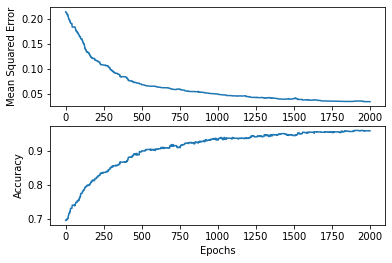

In [58]:
GD.fit(GD.X_train, GD.y_train ,learning='SGD', intialize = True, epochs=2000, learning_rate=0.015, display_loss=True)

Classification Report
                             
TP                        170
TN                        218
FP                         10
FN                         13
Total                     411
Accuracy   0.9440389294403893
Recall     0.9289617486338798
Precision  0.9444444444444444


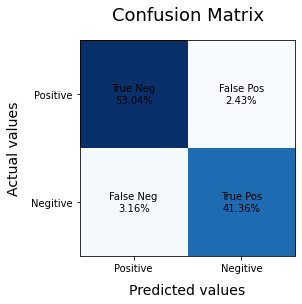

Loss :  0.03395592476659975
Most important feature is 'attr 4 '


In [61]:
GD.evaluate(GD.X_test, GD.y_test)
print('Loss : ', GD.lossList[-1])
print('Most important feature is \'attr', np.argmax(np.bincount(GD.attrList)), '\'')

### Learning Rate = 0.1 and Epochs = 2000 - Accuracy = 98.54% - Not Standardized

In [74]:
SGD1=LogReg(df)

Epoch: 0 Loss: 0.41933161639624866 Accuracy: 0.3927083333333333
Epoch: 50 Loss: 0.1795303125135905 Accuracy: 0.734375
Epoch: 100 Loss: 0.13438193914281935 Accuracy: 0.7947916666666667
Epoch: 150 Loss: 0.09791522054896111 Accuracy: 0.8583333333333333
Epoch: 200 Loss: 0.060538392288145074 Accuracy: 0.921875
Epoch: 250 Loss: 0.04961337705585591 Accuracy: 0.9333333333333333
Epoch: 300 Loss: 0.04084194758017154 Accuracy: 0.953125
Epoch: 350 Loss: 0.03979722153445916 Accuracy: 0.9510416666666667
Epoch: 400 Loss: 0.03437458182151055 Accuracy: 0.9572916666666667
Epoch: 450 Loss: 0.03173766560167383 Accuracy: 0.9604166666666667
Epoch: 500 Loss: 0.032415975699697064 Accuracy: 0.9666666666666667
Epoch: 550 Loss: 0.02754941289844272 Accuracy: 0.971875
Epoch: 600 Loss: 0.025978054108154857 Accuracy: 0.975
Epoch: 650 Loss: 0.0237930907260878 Accuracy: 0.9770833333333333
Epoch: 700 Loss: 0.029625243828084895 Accuracy: 0.9729166666666667
Epoch: 750 Loss: 0.023200675399779925 Accuracy: 0.975
Epoch: 800

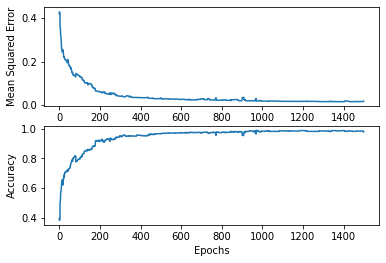

In [75]:
SGD1.fit(SGD1.X_train, SGD1.y_train ,learning='SGD', intialize = True, epochs=1500, learning_rate=0.1, display_loss=True)

In [118]:
print('Train Accuracy :', SGD1.accuracyList[-1])

Train Accuracy : 0.9791666666666666


Classification Report
                             
TP                        183
TN                        222
FP                          6
FN                          0
Total                     411
Accuracy   0.9854014598540146
Recall                    1.0
Precision  0.9682539682539683


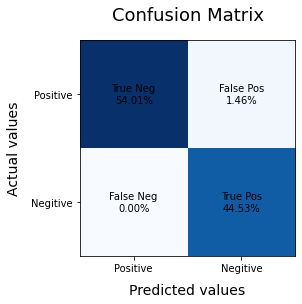

Loss :  0.017974918178084647
Most important feature is 'attr 4 '


In [76]:
SGD1.evaluate(SGD1.X_test, SGD1.y_test)
print('Loss : ', SGD1.lossList[-1])
print('Most important feature is \'attr', SGD1.attrList[-1], '\'')

### Learning Rate = 0.5 and Epochs = 1500 - Accuracy = 99.51% - Not Standardized

In [71]:
SGD=LogReg(df)

Epoch: 0 Loss: 0.4203536758111036 Accuracy: 0.49166666666666664
Epoch: 50 Loss: 0.07893311897052621 Accuracy: 0.8864583333333333
Epoch: 100 Loss: 0.03748846088532327 Accuracy: 0.94375
Epoch: 150 Loss: 0.1302077040434275 Accuracy: 0.8302083333333333
Epoch: 200 Loss: 0.03509026183255306 Accuracy: 0.9541666666666667
Epoch: 250 Loss: 0.0488380080220046 Accuracy: 0.9333333333333333
Epoch: 300 Loss: 0.04128196849060785 Accuracy: 0.946875
Epoch: 350 Loss: 0.01669608738849062 Accuracy: 0.98125
Epoch: 400 Loss: 0.10756373418567451 Accuracy: 0.871875
Epoch: 450 Loss: 0.03507384040245346 Accuracy: 0.9583333333333334
Epoch: 500 Loss: 0.036159558704515364 Accuracy: 0.9541666666666667
Epoch: 550 Loss: 0.016016106729831555 Accuracy: 0.978125
Epoch: 600 Loss: 0.04898172405255271 Accuracy: 0.9395833333333333
Epoch: 650 Loss: 0.023895728518742165 Accuracy: 0.971875
Epoch: 700 Loss: 0.07427691924920686 Accuracy: 0.909375
Epoch: 750 Loss: 0.05581739353565034 Accuracy: 0.93125
Epoch: 800 Loss: 0.0252953996

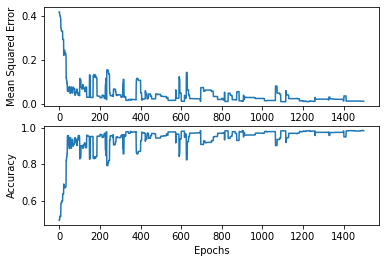

In [72]:
SGD.fit(SGD.X_train, SGD.y_train ,learning='SGD', intialize = True, epochs=1500, learning_rate=0.5, display_loss=True)

In [117]:
print('Train Accuracy :', SGD.accuracyList[-1])

Train Accuracy : 0.984375


Classification Report
                             
TP                        178
TN                        231
FP                          2
FN                          0
Total                     411
Accuracy   0.9951338199513382
Recall                    1.0
Precision  0.9888888888888889


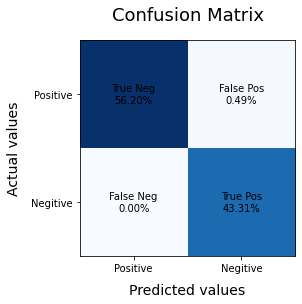

Loss :  0.01228070104107874
Most important feature is 'attr 4 '


In [73]:
SGD.evaluate(SGD.X_test, SGD.y_test)
print('Loss : ', SGD.lossList[-1])
print('Most important feature is \'attr', SGD.attrList[-1], '\'')

### MBSGD with batch size=10

Mini Batch Gradient Descent is a mix of regular Gradient Descent and Stochastic Gradient Deascent

In [77]:
trial1= LogReg(df, standardize=True)

Epoch: 0 Loss: 0.08988248878688496 Accuracy: 0.8958333333333334
Epoch: 50 Loss: 0.017886891445418416 Accuracy: 0.9770833333333333
Epoch: 100 Loss: 0.014775781981353573 Accuracy: 0.978125



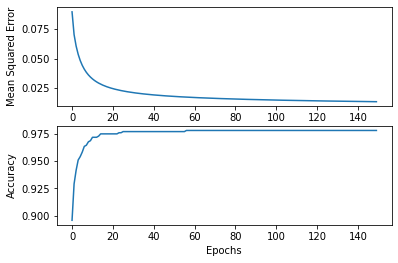

In [78]:
#trial1.cross_val(10, learning='MBSGD', epochs=150, learning_rate=0.015, batch_size=1)
trial1.fit(trial1.X_train, trial1.y_train ,learning='MBSGD', intialize = True, epochs=150, learning_rate=0.015, display_loss=True)

Classification Report
                             
TP                        102
TN                        226
FP                          0
FN                         83
Total                     411
Accuracy   0.7980535279805353
Recall     0.5513513513513514
Precision                 1.0


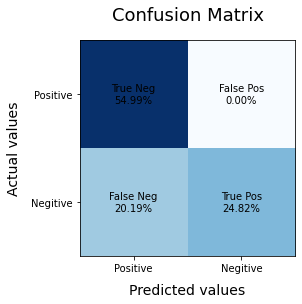

In [79]:
trial1.evaluate(trial1.X_test, trial1.y_test)